# Overdue HW 4 (oops :[ )


## Exercises

You may work in groups for these exercises. They are due at the beginning of next class. You can submit them as a link to a Colab notebook or GitHub CodeSpace.

0. Use the corpora that you assembled last week (Pausanias++):
1. Using programming techniques from the course so far, find other potential collocates for a word of your choice.
2. Calculate the μ and Mutual Information scores for at least 5 of these collocate pairs. How do your results change depending on your definition of a collocation? What might these changes mean? (Write your answers to these questions down.)
3. Calculate the Delta P for these same five pairs. Do any results stand out? Why? What might they tell us about your corpus.


## 0

In [ ]:
%pip install pip==24.0
%pip install -r requirements.txt
%run -m grecy install grc_proiel_sm

In [2]:
from lxml import etree
from MyCapytain.common.constants import Mimetypes
from MyCapytain.resources.texts.local.capitains.cts import CapitainsCtsText
import pandas as pd

with open("tlg0525.tlg001.perseus-grc2.xml") as f:
    text = CapitainsCtsText(urn="urn:cts:greekLit:tlg0525.tlg001.perseus-grc2", resource=f)

urns = []
raw_xmls = []
unannotated_strings = []

for ref in text.getReffs(level=len(text.citation)):
    urn = f"{text.urn}:{ref}"
    node = text.getTextualNode(ref)
    raw_xml = node.export(Mimetypes.XML.TEI)
    tree = node.export(Mimetypes.PYTHON.ETREE)
    s = etree.tostring(tree, encoding="unicode", method="text")

    urns.append(urn)
    raw_xmls.append(raw_xml)
    unannotated_strings.append(s)

d = {
    "urn": pd.Series(urns, dtype="string"),
    "raw_xml": raw_xmls,
    "unannotated_strings": pd.Series(unannotated_strings, dtype="string")
}
pausanias_df = pd.DataFrame(d)
pausanias_df['whitespaced_tokens'] = pausanias_df['unannotated_strings'].str.split()
#pausanias_df

In [3]:
# this will take a while

import spacy

nlp = spacy.load("grc_proiel_sm", disable=["ner"])

raw_texts = [t for t in pausanias_df['unannotated_strings']]
annotated_texts = nlp.pipe(raw_texts, batch_size=100)

pausanias_df['nlp_docs'] = list(annotated_texts)

## 1
Using programming techniques from the course so far, find other potential collocates for a word of your choice. 

In [4]:
from collections import Counter

def lemma_tize(c):
    return [b.lemma_ for b in c]

test_token = pausanias_df['nlp_docs'][0][1]
pausanias_df['my_lemmata'] = [lemma_tize(c) for c in pausanias_df['nlp_docs']]

# we use a list comprehension to evaluate the generator at `test_token.children`
f"token: '{test_token}, {test_token.lemma_}', dependencies: {[(c, c.lemma_) for c in test_token.children]}"

# λόγος time
#homer_son_lines = homer_df.loc[homer_df["unannotated_strings"].str.contains('son', regex=False)]
paus_word_lines = pausanias_df.loc[pausanias_df["my_lemmata"].str.contains('λόγος', regex=False)]

node_cnt = 0
token_cnt = 0
collocates = []
for x in paus_word_lines['nlp_docs']:
    for y in x:
        token_cnt += 1
        if y.lemma_ == 'λόγος':
            collocates.extend([c.lemma_ for c in y.children])
            node_cnt += 1
        else:
            if 'λόγος' in [d.lemma_ for d in y.children]:
                collocates.append((y.lemma_))

cnt_locates = Counter(collocates)
#cnt_locates.most_common(20)
# sarah's five collocates: ἔχω, δηλόω, λέγω, ποιέω, εἰμί

## 2
Calculate the μ and Mutual Information scores for at least 5 of these collocate pairs. 

In [5]:
# sarah's five collocates: ['ἔχω', 'δηλόω', 'λέγω', 'ποιέω', 'εἰμί']

# mu = observed frequency of both / expected frequency of both
# e_11 = node count * 2 * collocate count / token count

from math import log2

node_cnt = 0
token_cnt = 0
collocate_dictionary = {'ἔχω': [0, 0], 'δηλόω':[0, 0], 'λέγω':[0, 0], 'ποιέω':[0, 0], 'εἰμί':[0, 0]}
for x in pausanias_df['nlp_docs']:
    for y in x:
        token_cnt += 1
        collocates = []
        if y.lemma_ in collocate_dictionary:
            collocate_dictionary[y.lemma_][0] += 1
        if y.lemma_ == 'λόγος':
            collocates.extend([c.lemma_ for c in y.children])
            node_cnt += 1
        elif 'λόγος' in [d.lemma_ for d in y.children]:
            collocates.append((y.lemma_))
        
        for collocate in collocates:
            if collocate in collocate_dictionary:
                collocate_dictionary[collocate][1] += 1

e_11s = []

for key in collocate_dictionary:
    e_11_num = node_cnt * 2 * collocate_dictionary[key][0]
    final_e_11 = e_11_num/token_cnt
    mu = collocate_dictionary[key][1] / final_e_11
    mi = log2(mu)
    print(key, " has a mu of ", mu, " and a MI of ", mi)



ἔχω  has a mu of  7.513978936145689  and a MI of  2.90957707169425
δηλόω  has a mu of  38.363070539419084  and a MI of  5.261646291643503
λέγω  has a mu of  4.296899346954497  and a MI of  2.103295982987964
ποιέω  has a mu of  4.239655059234869  and a MI of  2.083946891067951
εἰμί  has a mu of  0.7784178446231346  and a MI of  -0.3613833117284921


How do your results change depending on your definition of a collocation? What might these changes mean? (Write your answers to these questions down.)

Let's say we were to make our window size a little bigger. That means our observed collocations will either grow or stay about the same, while the number of expected collocations will get bigger because our window size is a factor multiplied in the numerator of this equation, observed collocations will impact this score in one of two ways. If the number of observed collocations grows significantly, a numerator growing at the same rate as the denominator is likely, and the ratio stays the same. However, if the window size does not significantly affect the number of observed collocations, MU will shrink, since the observed frequency stays the same and the expected frequency grows.

## 3
Calculate the Delta P for these same five pairs. Do any results stand out? Why? What might they tell us about your corpus.

ἔχω  has a Delta P of  0.06597511051048267  ;  0.027679882813743763
δηλόω  has a Delta P of  0.0451369153664118  ;  0.1488095238095238
λέγω  has a Delta P of  0.03673758676384054  ;  0.014986062825095438
ποιέω  has a Delta P of  0.03667226571086517  ;  0.014761091113122795
εἰμί  has a Delta P of  0.011896274911105092  ;  0.001117413089543416


<Axes: xlabel='x', ylabel='y'>

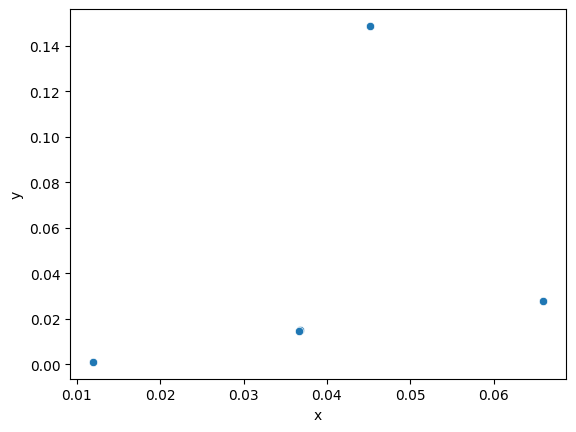

In [9]:
import seaborn as seaboo

r1 = node_cnt 
r2 = token_cnt - node_cnt

delta_p_as = []
delta_p_bs = []

for collocate in collocate_dictionary:
    local_c1 = collocate_dictionary[collocate][0]
    local_c2 = token_cnt - local_c1
    local_o11 = collocate_dictionary[collocate][1]
    local_o12 = r1 - local_o11
    local_o21 = local_c1 - local_o11

    delta_p_a = (local_o11 / r1) - (local_o21 / r2)
    delta_p_b = (local_o11 / local_c1) - (local_o12 / local_c2)
    delta_p_as.append(delta_p_a)
    delta_p_bs.append(delta_p_b)
    print(collocate, " has a Delta P of ", delta_p_a, " ; ", delta_p_b)

delta_ps = pd.DataFrame({'x':pd.Series(delta_p_as), 'y':pd.Series(delta_p_bs)})
seaboo.scatterplot(data = delta_ps, x='x',y='y')


We have two outliers as determined by their strength in relation to both probabilistic scores, which you can see printed above and also visualized on this graph. In Pausanias, ἔχω (carry, bring) has the highest first probability, which means that it is more likely to see this word collocated with λόγος than others on this graph. However, δηλόω (show, make visible) has the highest second probability, which means that of all words δηλόω is collocated with, λόγος is more likely to be collocated with it than other collocates. The first statistic is more frequency-based (how often is the collocate found with the node) and the second statistic is more based on strength of association (how often does the collocate has the node as one of its collocates). This previous observation may seem like a minor distinction, but though δηλόω has a lower first score than ἔχω, that could mean that δηλόω appears less time in the text than ἔχω, but the percentage of  of δηλόω's collocates that are the node is higher than that same percentage for ἔχω, meaning that δηλόω may be a slightly more exclusive pair with the node than ἔχω. If time allows, I wish to calculate Delta P of collocates for my final project and compare both measures on how well they meet the goal of disentangling frequency from association strength.